In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
#from bs4 import BeautifulSoup
from collections import defaultdict
#import requests
%matplotlib inline
from sklearn.svm import SVC
from nltk.stem.snowball import SnowballStemmer

## remove special symbol

def clean_text(df_tem3,col):
    df_tem3[col] = df_tem3[col].str.replace("&#039;",'\'')
    df_tem3[col] = df_tem3[col].str.replace("\"","").str.lower()
    df_tem3[col] = df_tem3[col].str.replace( r"(\\r)|(\\n)|(\\t)|(\\f)|(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(&#039;)|(\d\s)|(\d)|(\/)","")
    df_tem3[col] = df_tem3[col].str.replace("\"","").str.lower()
    df_tem3[col] = df_tem3[col].str.replace( r"(\$)|(\-)|(\\)|(\s{2,})"," ")
    df_tem3[col].sample(1).iloc[0]

    stemmer = SnowballStemmer('english')
    df_tem3[col] = df_tem3[col].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split(" ")]))
    return df_tem3[col]


np.random.seed(9)

In [247]:
df = pd.read_csv("../web_scrap.csv",index_col=0).drop_duplicates()
df_tem3 = clean_text(df,'9')


In [248]:
#y = ((df['3'] != ' No Side Effects') & (df['3'] != ' Mild Side Effects')).astype(int)
y = (df['3'] != ' No Side Effects').astype(int)
X = df_tem3

In [249]:
y.mean()

0.7084134615384615

In [250]:
for se_com in df[((df['3'] != ' No Side Effects') & (df['3'] != ' Mild Side Effects'))]['9'].sample(10):
    print(se_com+'\n')
    print("===========================")

 a few day a week my face would be red veri sensit and peel then it would be back to normal and then a few day later the peel start again

 dri skin and eye flake skin and bloodi nose howev the most pertin side effect was depress 

 extrem aggress delus

 some drowsi at night after taken it throughout the day and some constip howev after take it for onli two week i had a seizur that sent me to hospit and was told by doc there that elavil and tramadol combin can caus seizur no one told me this not my primari care doc my gi doc or the pharmacist this seem to me to be a pretti sever side effect for a medicin that bare work the two med were prescrib to me by the same physician and i understand oversight can happen howev if i had known from begin that seizur might be a possibl i would ask for someth els also after onli two week i had some weird effect after stop usag includ diarrhea cold sweat hot flash restless leg syndrom and anxieti i never experienc anyth like this with ani other med th

In [251]:
for se_com in df[~((df['3'] != ' No Side Effects') & (df['3'] != ' Mild Side Effects'))]['9'].sample(10):
    print(se_com+'\n')
    print("===========================")

 notic growth of eyelash becom thicker and lusher becaus of the eye drop

 no real assist or side efect were notic

 none

 none

 the antibiot creat a sens of nausea throughout the dayin addit i have to take my pro biotic in order to prevent the common yeast infect that come with the antibiot 

 none that i am awar of

 some sunlight sensit sunburn more easili and reduc sperm count

 no side effect so far onli a slight itch around the inject site from time to time

 for the first month of take ortho tri cyclen i was a littl moodi when my period start the first month i was veri moodi but that onli last about day the second month of my period my pms calm down and now i have no mood swing and onli one day of cramp

 i did not have ani notic side effect from this medic



In [252]:
# Split Training & Test Data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2)

In [253]:
import tensorflow as tf
import tensorflow 

#from tensorflow import tensorflow.keras

#from keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D 
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional



# fix random seed for reproducibility

MAX_NB_WORDS = 500
max_review_length = 500
EMBEDDING_DIM = 160


In [254]:
# Tokenize the data
tokenizer = Tokenizer(num_words = MAX_NB_WORDS, 
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
                      lower=True, split=' ', char_level=False, 
                      oov_token=None, document_count=0)

tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# truncate and pad input sequences
X_train = sequence.pad_sequences(train_sequences, maxlen=max_review_length)
X_test = sequence.pad_sequences(test_sequences, maxlen = max_review_length)

word_index = tokenizer.word_index

In [255]:
nb_words  = min(MAX_NB_WORDS, len(word_index))
lstm_out = max_review_length

model = Sequential()
model.add(Embedding(nb_words,EMBEDDING_DIM,input_length=max_review_length))
#model.add(Dropout(0.2))

## add conv using kernal No.32 and size 3x3, actiation='relu'(rm neg)
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPool1D(pool_size=2))
model.add(Bidirectional(LSTM(20, return_sequences=True)))
#model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(20)))
#model.add(Attention(max_review_length))
model.add(Dense(1, activation = 'sigmoid'))

## one-code mutiple categories targets use 'categorical_crossentropy' not 'binary_crossentropy'
model.compile(loss='binary_crossentropy',optimizer='adam',metrics =['accuracy'])

In [256]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 500, 160)          80000     
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 500, 40)           28960     
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 40)                9760      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 41        
Total params: 118,761
Trainable params: 118,761
Non-trainable params: 0
_________________________________________________________________


In [257]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Run LSTM Model
batch = 32 
epoch = 40

early_stopping = EarlyStopping(patience = 3)

LSTM_model = model.fit(X_train, y_train, batch_size=batch, epochs=epoch,
                       validation_split=0.2,callbacks=[early_stopping], shuffle = True)

best_score = min(LSTM_model.history['val_loss'])

/home/ubuntu/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2662 samples, validate on 666 samples
Epoch 1/40
2662/2662 [==============================] - 64s 24ms/step - loss: 0.5210 - acc: 0.7750 - val_loss: 0.3421 - val_acc: 0.8904
Epoch 2/40
2662/2662 [==============================] - 55s 21ms/step - loss: 0.3183 - acc: 0.8948 - val_loss: 0.3039 - val_acc: 0.8919
Epoch 3/40
2662/2662 [==============================] - 55s 21ms/step - loss: 0.2656 - acc: 0.9050 - val_loss: 0.2881 - val_acc: 0.8964
Epoch 4/40
2662/2662 [==============================] - 55s 21ms/step - loss: 0.2230 - acc: 0.9252 - val_loss: 0.3098 - val_acc: 0.8994
Epoch 5/40
2662/2662 [==============================] - 55s 21ms/step - loss: 0.2017 - acc: 0.9350 - val_loss: 0.3386 - val_acc: 0.8904
Epoch 6/40
2662/2662 [==============================] - 55s 21ms/step - loss: 0.1762 - acc: 0.9452 - val_loss: 0.3426 - val_acc: 0.8904


In [258]:
LSTM_model_history = pd.DataFrame(LSTM_model.history)
file_name = "web_20_bilstm_2layer.csv"
LSTM_model_history.to_csv( file_name)

In [259]:
print(LSTM_model_history)

        acc      loss   val_acc  val_loss
0  0.774981  0.520957  0.890390  0.342128
1  0.894816  0.318262  0.891892  0.303892
2  0.904959  0.265552  0.896396  0.288140
3  0.925244  0.223020  0.899399  0.309773
4  0.935011  0.201723  0.890390  0.338649
5  0.945154  0.176243  0.890390  0.342597


In [260]:
#model.save("web_20_bilstm_2layer.h5")

Text(0.5,0,'epoch')

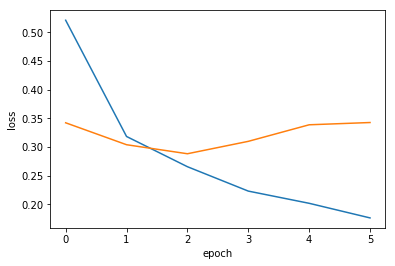

In [261]:
plt.plot(LSTM_model.history['loss'],label='train')
plt.plot(LSTM_model.history['val_loss'],label='validation')
plt.ylabel("loss")
plt.xlabel("epoch")

In [262]:
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import load_model
#model = load_model("web_20_bilstm_2layer.h5")
#LSTM_model = model.fit(X_train, y_train, batch_size=batch, epochs=epoch)

accr = model.evaluate(X_test,y_test, batch_size = 100)
accr

832/832 [==============================] - 2s 2ms/step


[0.3778531223248977, 0.871394223605211]

In [263]:
#             acc      loss   val_acc  val_loss
#     0  0.670173  0.597171  0.770270  0.465685
#     1  0.800902  0.425928  0.779279  0.446773
#     2  0.849737  0.355651  0.794294  0.434360
#     3  0.869647  0.318369  0.800300  0.442692
#     4  0.886927  0.287467  0.801802  0.473488
#     5  0.900826  0.256769  0.792793  0.538440

#     [0.9755449504233323, 0.6394230763499553]

#     array([[373, 133],
#            [167, 159]])

In [264]:
y_test_pred = model.predict_classes(X_test)
confusion_matrix(y_test,y_test_pred)

array([[187,  63],
       [ 44, 538]])

In [266]:
y_test_pro = model.predict_proba(X_test)

0.9044776632302406


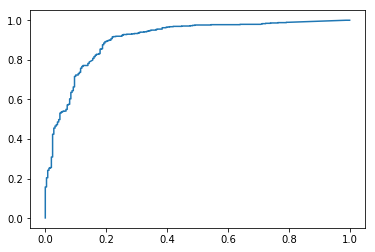

In [267]:
from sklearn.metrics import roc_auc_score, roc_curve
print(roc_auc_score(y_test,y_test_pro))
fpr, tpr, thre = roc_curve(y_test,y_test_pro)

plt.plot(fpr,tpr)

## predict sentence

In [174]:
first_quest2 = pd.read_csv("../wit_ai_sentment/SE_tem_l400_first_request.ccv",index_col=0)

In [199]:
y_wit = ((first_quest2['value'] == "negative")).astype(int)
X_wit = clean_text(first_quest2,'text')

In [200]:
X_wit_sequences = tokenizer.texts_to_sequences(X_wit)
X_wit_trans = sequence.pad_sequences(X_wit_sequences, maxlen = max_review_length)


In [201]:
accr = model.evaluate(X_wit_trans,y_wit, batch_size = 100)
accr

30689/30689 [==============================] - 71s 2ms/step


[1.094872981872162, 0.6102186445966292]

In [202]:
y_test_pred = model.predict_classes(X_wit_trans)
confusion_matrix(y_wit,y_test_pred)

array([[10745,  3179],
       [ 8783,  7982]])

In [180]:
## [1.620907984605271, 0.5002443838369665]
## array([[11736,  2188],
##       [13149,  3616]])

In [192]:
for sen in X_wit[y_test_pred.flatten() == 1].sample(10):
    print(sen+"\n")
    print("==================================")

my onli side effect is weight gain

ive been on desvenlafaxin actavi for over year now for anxietyang and depress i was see a psychologist for the first three month of have the drug an experienc minim side effect a littl dizzi here and there

it help with some of the fibro pain and i felt tire and a littl dizzi along with have dri mouth which i expect as common side effect

it did stop the migrain but the other side effect were horribl

the reason be is becaus your bodi is adjust to the new birth control and of cours your go to experi break out bleed common birth control side effect and of cours be over emot

hope the side effect dont worsen and the benefit continu

no side effect mayb weight gain but im also eat again when befor i was bare eat and drop lbs

the onli anti inflammatori med i could take without side effect

all test were negat and they hospit sent this compani a letter state they need to add stroke to their list of side effect

i tri various antidepress which had the usu

In [ ]:
## 8/10(8.5/10)

In [193]:
for sen in X_wit[y_test_pred.flatten() == 0].sample(10):
    print(sen+"\n")
    print("==================================")

so far i have had no side effect and no problem with it

notic within a few hour i was have side effect

i have ibd so mayb i had stomach upset as a side effect but it was noth out of the ordinari for me so didnt notic

i had no notic side effect and everyth went well

no sexual side effect

cymbalta did absolut noth for pain ive had no side effect from the drug at all none i did a less than day switch over from cymbalta to savella with advers effect or side effect this medicin is work both for the depress &amp

i love how effect it is as a birth control but i cant stand the side effect

it has complet prevent ani pregnanc and i never had one negat side effect

it doe have a side effect of drowsi a clumsi effect but the sleep i get is wonder

im so fortun in that ive had no side effect i know that some are experienc terribl side effect but i want to chime in and say that not everyon experi them



In [ ]:
## 6/10

## predict comments with wit lableled

In [208]:
drugsComTrain = pd.read_csv('../drugsCom_raw/drugsComTrain_raw.tsv',sep='\t',index_col=0)#.sample(40000)


In [222]:
first_quest3 = pd.merge(first_quest2,drugsComTrain,left_index=True,right_index=True,how='left')
y_wit = ((first_quest3['value'] == "negative")).astype(int)
X_wit = clean_text(first_quest3,'review')

In [223]:
X_wit_sequences = tokenizer.texts_to_sequences(X_wit)
X_wit_trans = sequence.pad_sequences(X_wit_sequences, maxlen = max_review_length)

accr = model.evaluate(X_wit_trans,y_wit, batch_size = 100)
accr

30689/30689 [==============================] - 71s 2ms/step


[1.4372596507346067, 0.5778617738197461]

In [224]:
y_test_pred = model.predict_classes(X_wit_trans)
confusion_matrix(y_wit,y_test_pred)

array([[ 4008,  9916],
       [ 3039, 13726]])

In [225]:
for sen in X_wit[y_test_pred.flatten() == 1].sample(10):
    print(sen+"\n")
    print("==================================")

i have been on zoloft for a year to treat ocd this drug has taken away my pain and destruct symptom though this is a process that has been aid by intens talk therapi my side effect are increas in intens as time goe on main dri mouth and nausea howev terribl these side effect may sound i would rather deal with them than the symptom of ocd and depress on ani given day

i&rsquov taken clindamycin a coupl time over the last few year and have had minor side effect heart burn is the worst side effect i have experienc but i start take the pill dure meal and it help great i guess it&rsquo becaus it&rsquo go down with other food and not by itself this antibiot is definit strong and doe the job of get rid of infect take some probiot and zantac with it and you&rsquol be good to go

i had been on plaquenil for near year for lupus so long that i didnt rememb ani side effect i saw my rheumatologist recent and he said that he felt that i was in remiss so i decid to come off of it for awhil within a w

In [ ]:
## 8/10(7.5/10)

In [226]:
for sen in X_wit[y_test_pred.flatten() == 0].sample(10):
    print(sen+"\n")
    print("==================================")

have suffer chronic knee and lower back pain for year sever osteoarthr of both knee and have torn and bulg disc age i am so grate to the locum who initi prescrib oxycontin month ago now mg x   a prescript for the first time which has lessen the pain and at last improv my qualiti of life i was veri reluct to tri an opiat and remain on a lower dose by choic for me the side effect and fear of becom depend is far outweigh by the relief provid all medicin can be abus and can have side effect   it a fine balanc but genuin chronic pain suffer must not be deni an effect treatment

i am an alcohol in recoveri and have been sober for over year i use this drug when it was fair new and i was in rehab seem to work along with all the other tool given to me at that time no side effect that i can recal

i have been take anastrazol mg daili sinc for the treatment of breast cancer i have not receiv chemotherapi or radiat this is truli a dread diseas that impos a life sentenc on you i too can attest to s

In [ ]:
# 7/10

## predict comments without wit lableled

In [230]:
test = pd.read_csv("../drugsCom_raw/drugsComTest_raw.tsv",sep='\t', index_col=0)
X_wit = clean_text(test,'review')

In [231]:
X_wit_sequences = tokenizer.texts_to_sequences(X_wit)
X_wit_trans = sequence.pad_sequences(X_wit_sequences, maxlen = max_review_length)

In [233]:
y_test_pred = model.predict_classes(X_wit_trans)

In [234]:
for sen in X_wit[y_test_pred.flatten() == 1].sample(10):
    print(sen+"\n")
    print("==================================")

i began treatment on qsymia under my physician care in march at lbs and follow simpl step toward chang my eat habit and amp up my exercis regimin it was not an overnight result i had up and down definit more posit than negat today i weigh lbs i am a yr old grandmoth and feel better and more youth than i did or more year ago my eat is a lifestyl not a diet my exercis is my therapi that make me happi the two combin give me a healthi bodi and qsymia jump start it all go into it with the right frame of mind and determin will make all the differ qsymia is the tool that work for me and i love what it did for me

it help but unfortun all walmart in reno nv are constant out of stock i went to a pharmaci think sur they must stock the product but i had no luck the pharmacist had no i deal what this product was i felt like the pharmacist thought i was ask for oxycontin i wish they would chang the name and stock the store better with this product what a shame now i will have to depend on a physici

In [235]:
for sen in X_wit[y_test_pred.flatten() == 0].sample(10):
    print(sen+"\n")
    print("==================================")

i start this contracept at to control my acn and it did a great job i had no problem i did experi a lack of hunger it was kinda weird but it didnt effect my life i just had to make myself eat now that i am i have no side effect at all i havent realli put it to the test in prevent pregnanc but im not pregnant and havent been so that also a plus

this medic is excel i have had horribl angioedema a type of urticaria where the hive form under the skin sinc i was ten year old from an autoimmun diseas and have gone through sever differ medic but this onc has work the most effect and i can tell how well it work becaus when i forget to take it the hive show up within about hour after the miss dose and onc i rememb to take the miss dose within about two hour it feel as though i never had angioedema at all

i know it work but i have realli bad breath never befor have i had a problem with that but know i cannot eat enough mint i will take that side effect becaus i feel % better

i have a veri stu

In [ ]:
## 7/10 (6.5/10)